---
title: Bruker - Digital Filter Group Delay
---

In [2]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

If you have ever loaded raw Bruker spectroscopy data and wondered why your Free Induction Decay (FID) starts with a strange, wavy flatline instead of a sharp peak — or why your uncorrected spectrum looks like a spinning corkscrew  — you have encountered the **digital filter group delay**.

This is not a glitch or a bad acquisition. It is a direct physical byproduct of how modern spectrometers digitize and filter high-frequency radio signals. To understand how to fix it, we first need to look under the hood.

## The Hardware Pipeline

In modern MRI and MRS, analog-to-digital conversion (ADC) happens much faster than your final requested dwell time. The Bruker AVANCE NEO, for example, is a fully digital hardware system.

When your signal is detected, it is mixed down to a suitable frequency band and sampled at a massive rate (often 240 MHz or higher). To reduce this firehose of data down to your specific sweep width, the system uses a cascade of configurable Finite Impulse Response (FIR) filters implemented in an FPGA, combined with downsampling (decimation).

```mermaid
graph LR
    A[RF Coil] --> B[Preamplifier]
    B --> C[Mixer / Demodulator]
    C --> D[ADC <br/> 240 MHz]
    D --> E[Digital Hilbert <br/> Transform]
    E --> F[FIR Filter Cascade <br/> & Decimation]
    F --> G[Raw FID Data <br/> Shifted & Delayed]

    style D fill:#f9f,stroke:#333,stroke-width:2px
    style F fill:#bbf,stroke:#333,stroke-width:2px

```

## The "Causality" Problem

The FIR filters used to clean up the signal are symmetric to ensure a constant group delay across all frequencies.

:::{dropdown} Deep Dive: What exactly is "Group Delay"?

In digital signal processing, **delay** is simply the time it takes for a signal to pass through a filter.

While only one physical signal—the FID—enters the filter, that FID is mathematically a **"group" of many different frequencies** .

If a filter processed high frequencies faster than low frequencies, the internal components of your FID would get out of sync, physically smearing and distorting the shape of the wave.

To prevent this, Bruker designs their filters to be perfectly symmetrical. A strict mathematical rule is that symmetric filters possess a **constant group delay**. This means every single frequency making up your FID is delayed by the *exact same amount of time*. Your FID stays perfectly intact; it is just shifted in time by N points.
:::

However, because a symmetric filter calculates a moving average using points *before* and *after* a given moment in time, it cannot output the "center" of the data until its entire filter window has filled up.

When the sudden, sharp burst of your FID hits this empty filter, it takes a fraction of a millisecond to "wake up." The output ramps up in a wavy step response , effectively delaying the start of your true signal by a specific number of data points.

For spectroscopy, Bruker prioritizes absolute raw data transparency. Rather than artificially truncating this transient or hiding points from the user, the system passes the raw, uncompensated output directly to you. If left untouched, this time-domain shift results in a massive, rolling linear phase error in the frequency domain.

Let's use `xmris` to sanitize this raw hardware data and see exactly how to recover a pristine spectrum.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is imported so .xmr is registered
import xmris

## 1. Generate Synthetic Bruker-like Data (Hardware Simulation)
Let's create an FID with a known group delay of 76.125 points.

We will physically simulate the hardware DSP. A symmetric FIR filter of length $L$ introduces an exact group delay of $(L-1)/2$ points. We will convolve our "ideal" FID with a low-pass FIR filter to naturally generate the integer delay and the wavy hardware transient, followed by a frequency-domain phase shift for the sub-point fraction.

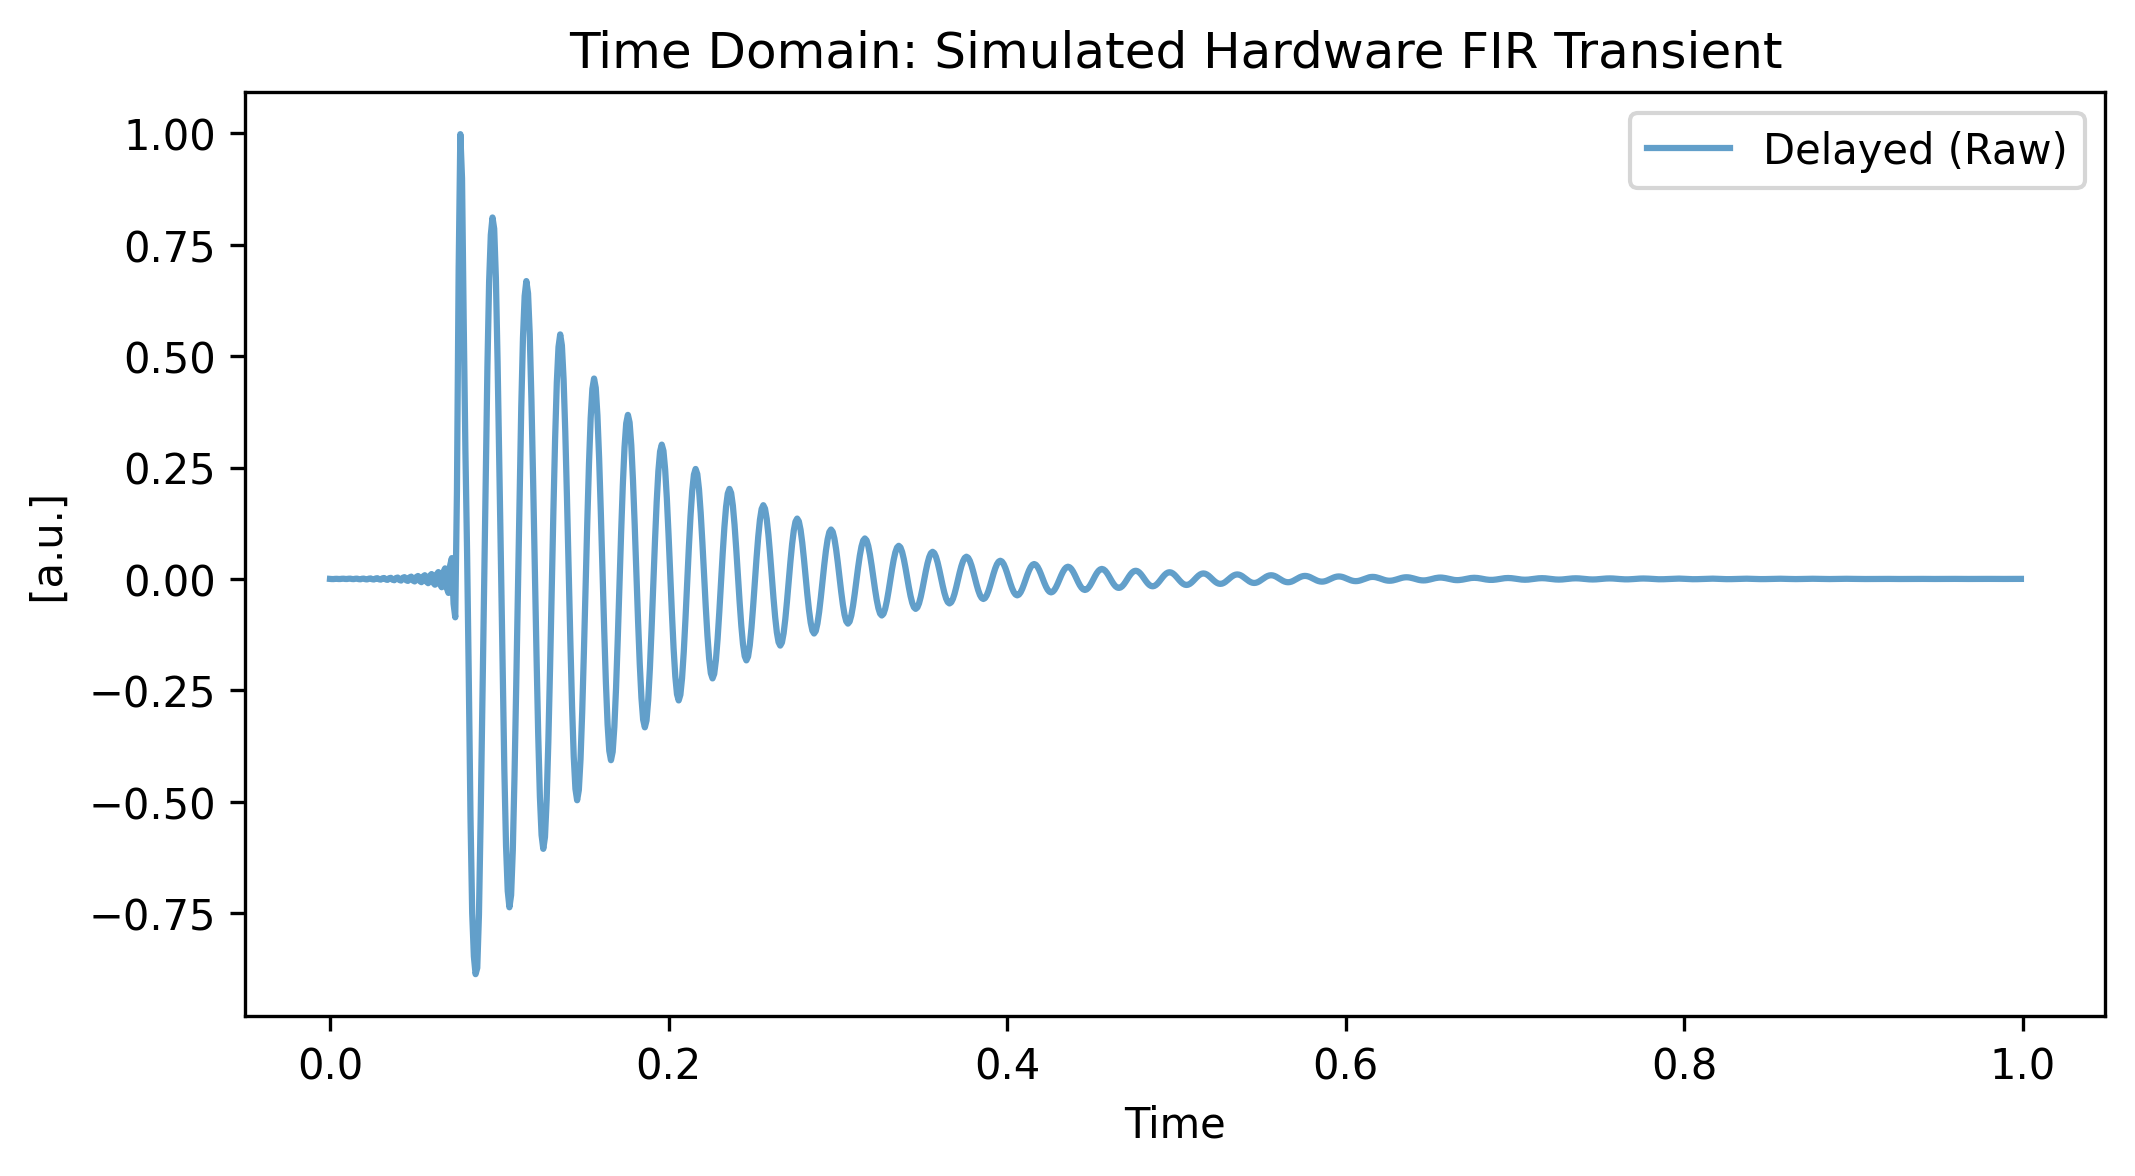

In [4]:
n_points = 1000
dt = 0.001
time = np.arange(n_points) * dt
freq = 50.0  # 50 Hz signal
decay = 10.0

# 1. True signal (starts sharply at t=0)
true_fid = np.exp(-time * decay) * np.exp(1j * 2 * np.pi * freq * time)

# 2. Define the Bruker Group Delay (76.125 points)
delay_points = 76.125
int_delay = int(np.floor(delay_points))
frac_delay = delay_points - int_delay

# 3. Simulate the FIR Hardware Filter (Integer delay + Wavy Transient)
# A symmetric filter of length 2N + 1 has a delay of N points.
fir_length = 2 * int_delay + 1
n = np.arange(fir_length)

# Create a simple low-pass filter (windowed sinc)
alpha = 0.54  # Hamming window
window = alpha - (1 - alpha) * np.cos(2 * np.pi * n / (fir_length - 1))
sinc_filter = np.sinc(0.5 * (n - int_delay)) * window
sinc_filter /= np.sum(sinc_filter)  # Normalize gain

# Apply hardware filter via convolution
# mode='full' naturally simulates the empty filter filling up with the new signal
hardware_fid = np.convolve(true_fid, sinc_filter, mode="full")[:n_points]

# 4. Apply the fractional sub-point delay via Fourier phase shift
spectrum = np.fft.fft(hardware_fid)
freqs = np.fft.fftfreq(n_points)
shifted_spectrum = spectrum * np.exp(-1j * 2 * np.pi * freqs * frac_delay)
delayed_fid = np.fft.ifft(shifted_spectrum)

# Package into xarray
da_raw = xr.DataArray(
    delayed_fid,
    dims=["Time"],
    coords={"Time": time},
    attrs={"units": "a.u.", "description": "Raw Bruker Data"},
)

fig, ax = plt.subplots(figsize=(8, 4))
da_raw.real.plot(ax=ax, label="Delayed (Raw)", alpha=0.7)
ax.set_title("Time Domain: Simulated Hardware FIR Transient")
ax.legend()
plt.show()

## 2. Apply xmris Correction
We can easily sanitize this hardware-specific data using the `.xmr.remove_digital_filter()` method. We use `keep_length=True` to pad the end with pure zeros, maintaining our exact array length for FFTs. This approach allows us to chain operations directly on the ingested array.

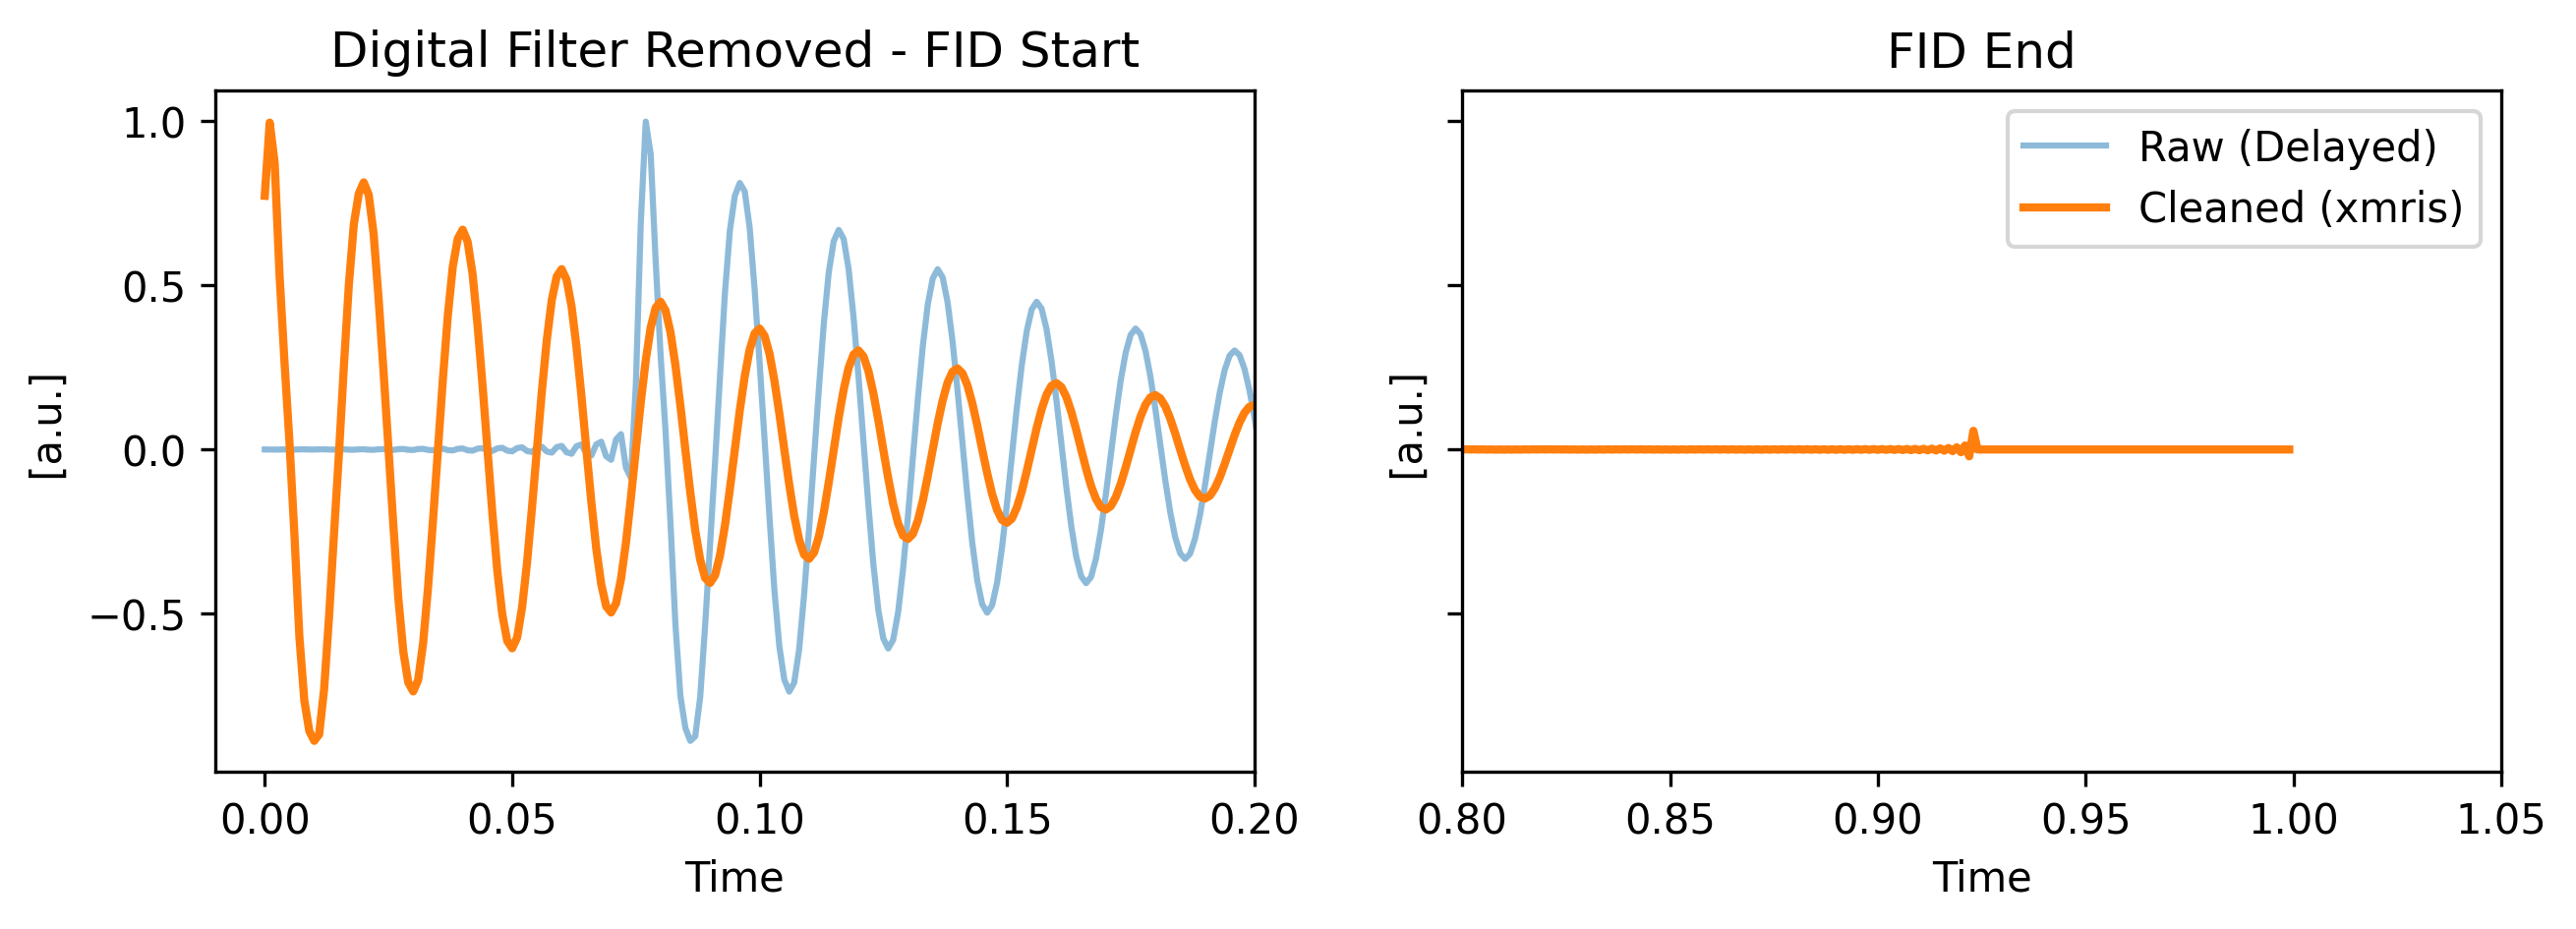

In [15]:
# 1. Sanitize the vendor-specific data using the accessor
da_clean = da_raw.xmr.remove_digital_filter(
    group_delay=delay_points, dim="Time", keep_length=True
)

# Plotting the Time Domain Result
fig, (ax_start, ax_end) = plt.subplots(figsize=(10, 3), ncols=2, sharey=True)

da_raw.real.plot(ax=ax_start, label="Raw (Delayed)", alpha=0.5)
da_clean.real.plot(ax=ax_start, label="Cleaned (xmris)", linewidth=2)
ax_start.set_xlim(-0.01, 0.2)
ax_start.set_title("Digital Filter Removed - FID Start")

da_raw.real.plot(ax=ax_end, label="Raw (Delayed)", alpha=0.5)
da_clean.real.plot(ax=ax_end, label="Cleaned (xmris)", linewidth=2)
ax_end.set_title("FID End")
ax_end.set_xlim(0.8, 1.05)
ax_end.legend()


plt.show()

## 3. Spectral Comparison (Naive vs. Clean)
A time shift corresponds to a linear phase shift. With a delay of ~76 points, the phase wraps around the unit circle 76 times across the spectral width!

Using the `.xmr.to_spectrum()` accessor, let's compare a naive FFT of the raw data versus an FFT of our sanitized data. We plot the **real** part to expose the severe phase twist.

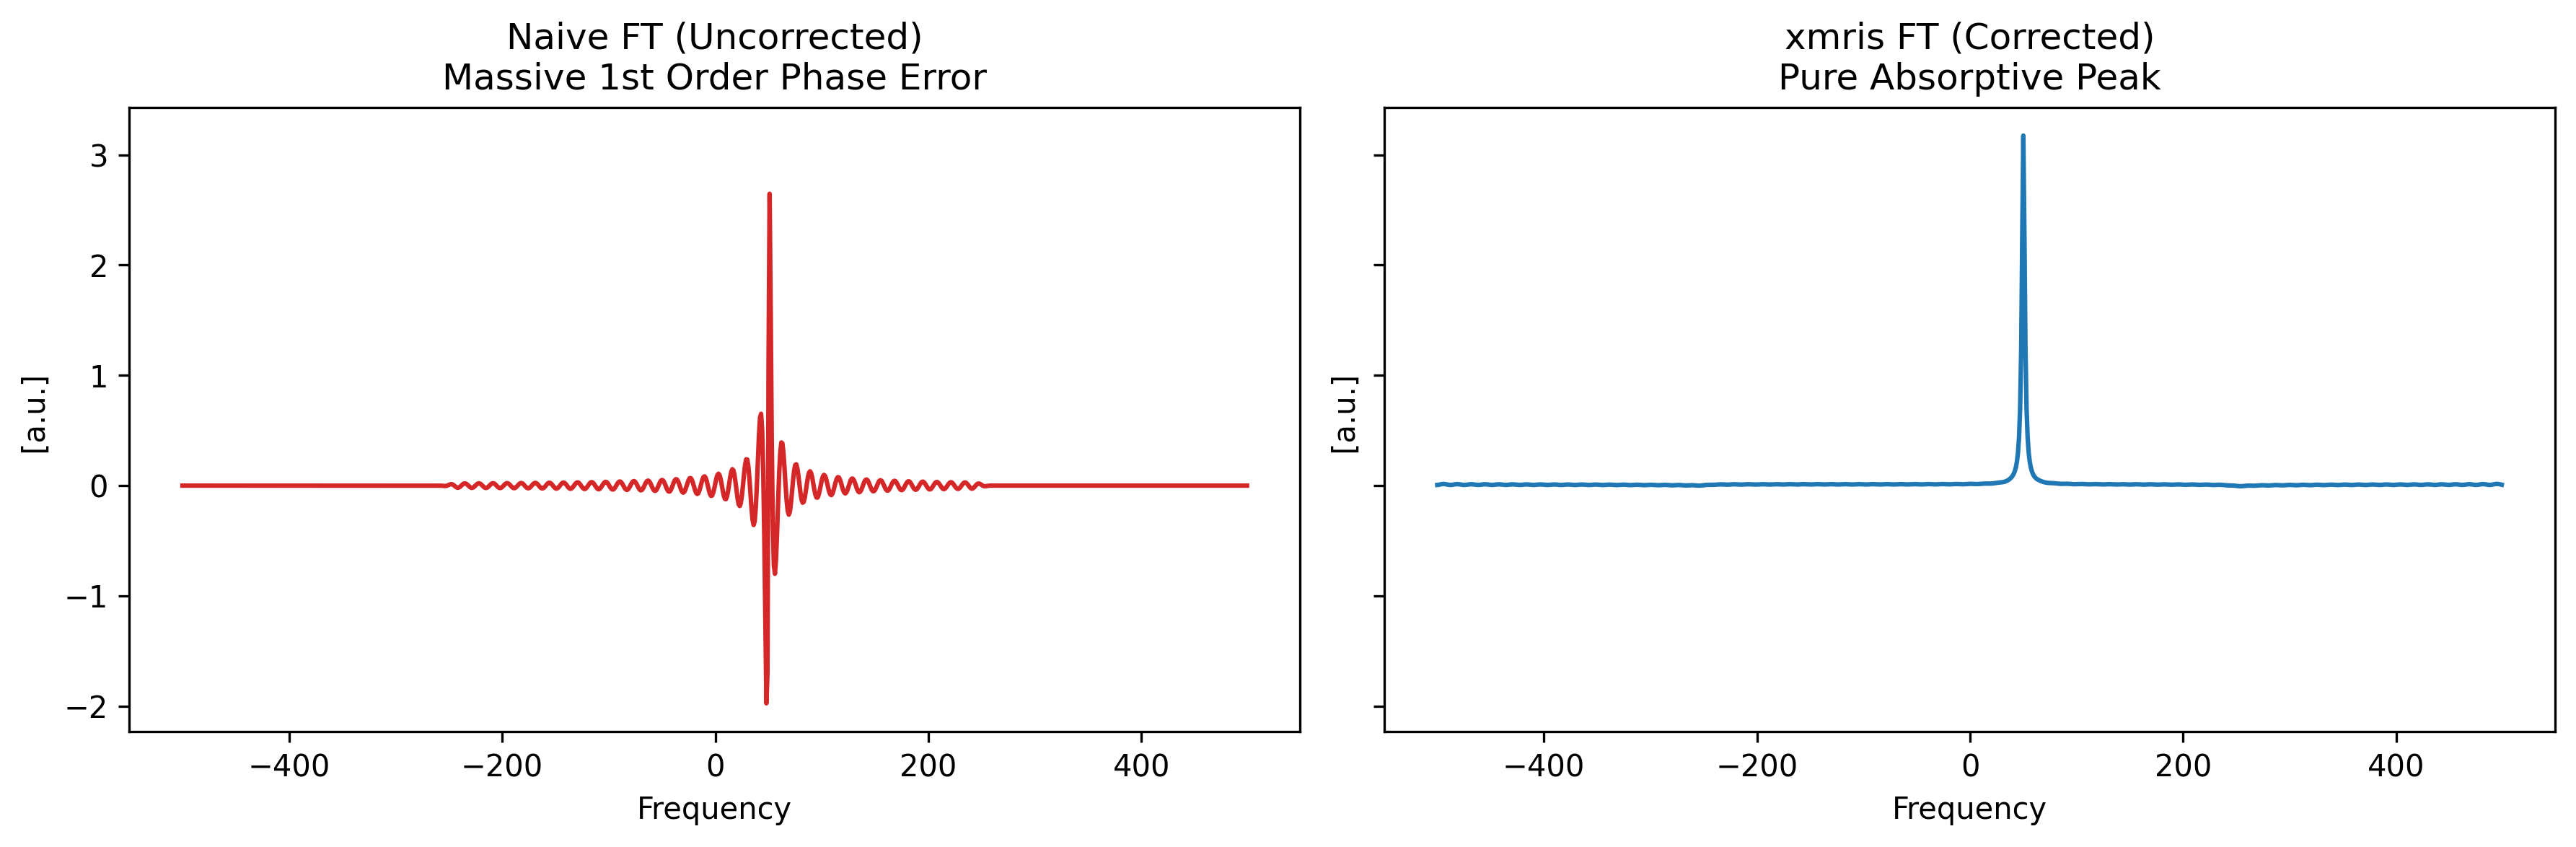

In [16]:
# Transform both arrays to the frequency domain using the xmris accessor
spec_raw = da_raw.xmr.to_spectrum(dim="Time", out_dim="Frequency")
spec_clean = da_clean.xmr.to_spectrum(dim="Time", out_dim="Frequency")

# Plotting the Frequency Domain Result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)


# Naive FFT
spec_raw.real.plot(ax=ax1, color="tab:red")
ax1.set_title("Naive FT (Uncorrected)\nMassive 1st Order Phase Error")

# Cleaned FFT
spec_clean.real.plot(ax=ax2, color="tab:blue")
ax2.set_title("xmris FT (Corrected)\nPure Absorptive Peak")

plt.tight_layout()
plt.show()

In [7]:
# CRITICAL ASSERTIONS FOR NBMAKE CI
# 1. Purity & Lineage checks
assert da_clean is not da_raw, "Function mutated data in place!"
assert "digital_filter_removed" in da_clean.attrs
assert da_clean.attrs["group_delay_removed"] == 76.125
assert da_clean.attrs["length_retained_with_zeros"] is True
assert da_clean.attrs["description"] == "Raw Bruker Data", (
    "Original attributes were lost!"
)

# 2. Dimensionality checks
assert da_clean.sizes["Time"] == 1000, "keep_length failed to maintain length."
np.testing.assert_allclose(
    da_clean.coords["Time"].values[0], 0.0, err_msg="Time coordinate not reset to 0"
)

# 3. Math checks (The zero filled region at the end should be strictly zero)
np.testing.assert_allclose(
    da_clean.values[-76:],
    0.0,
    atol=1e-12,
    err_msg="End of array was not zero-filled correctly",
)

# 4. Phase check in Time Domain
# Because the FIR filter "smears" the sharp starting spike, amplitude drops from 1.0 to ~0.77.
# We care that the phase is corrected, meaning the signal is primarily REAL and POSITIVE.
first_point = da_clean.values[0]
assert first_point.real > 0.5, (
    f"Real part {first_point.real} is too low (expected positive absorptive start)"
)
assert abs(first_point.imag) < 0.2, f"Imag part {first_point.imag} is not minimized"

# 5. Peak purity check in Frequency Domain
# Use np.argmax on the underlying numpy array to avoid xarray FutureWarnings
max_idx = np.argmax(abs(spec_clean).values)
peak_val = spec_clean.values[max_idx]

# The real part should strictly dominate the peak if perfectly phased
assert peak_val.real > 0, "Peak is not absorptive (real part is negative or zero)."
assert abs(peak_val.imag) < (peak_val.real * 0.15), (
    "Clean spectrum has residual phase error at the peak."
)